In [4]:
# Author: Jared A.Ergu
# License: CIS Lab--R301B, CCU, Taiwan
#**********************************
# QuantumHybrid_Train.ipynb      **
#**********************************
# ================================
# 1. IMPORTS & CONFIGURATION
# ================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from train_utils import TrainConfig, train_epochs
from data_handler import create_real_data_loaders, analyze_dataset_statistics, visualize_real_samples
from quantum_classical_hybrid import ModelConfig, create_hybrid_model, count_parameters


# Dataset paths
soi_dir = '/home/HardDisk/yared/spectrogram-dataset/soi'
cwi_dir = '/home/HardDisk/yared/spectrogram-dataset/cwi'

# Output directory
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ================================
# 2. Loading data from the two directoris
# ================================
data_loaders = create_real_data_loaders(
    soi_dir=soi_dir,
    cwi_dir=cwi_dir,
    batch_size=16,
    image_size=224,
    augment=True,
    balance_classes=True,
    max_samples_per_class=None,
    num_workers=8
)

In [6]:

# ================================
# 3. model parameters setup
# ================================
config = ModelConfig(
    n_qubits=6,
    n_layers=4,
    feature_dim=256,
    num_classes=2,
    input_channels=3,
    image_size=224
)

model = create_hybrid_model(config).to(device)
param_stats = count_parameters(model)
print(param_stats)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'classical_parameters': 11315106, 'quantum_parameters': 612, 'total_parameters': 11315718}


In [7]:

# ================================
# 4. Checking training loop
# ================================

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)['logits']
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return total_loss / len(loader), acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)['logits']
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    return total_loss / len(loader), acc


In [8]:

# ================================
# 5. training for 25 epcohs
# ================================

epochs = 25
train_loader = data_loaders['train']
val_loader = data_loaders['val']

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    print(f"\n--- Epoch {epoch+1}/{epochs} ---")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2%}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.2%}")

    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pt"))


--- Epoch 1/25 ---


Validation: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]


Train Loss: 0.6464, Accuracy: 60.62%
Val   Loss: 0.5281, Accuracy: 93.19%

--- Epoch 2/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


Train Loss: 0.5294, Accuracy: 77.27%
Val   Loss: 0.4039, Accuracy: 96.67%

--- Epoch 3/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]


Train Loss: 0.4406, Accuracy: 85.04%
Val   Loss: 0.3139, Accuracy: 95.92%

--- Epoch 4/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


Train Loss: 0.3668, Accuracy: 88.67%
Val   Loss: 0.2277, Accuracy: 97.43%

--- Epoch 5/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]


Train Loss: 0.3099, Accuracy: 92.00%
Val   Loss: 0.2290, Accuracy: 93.80%

--- Epoch 6/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


Train Loss: 0.2691, Accuracy: 93.49%
Val   Loss: 0.1575, Accuracy: 97.28%

--- Epoch 7/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]


Train Loss: 0.2248, Accuracy: 95.27%
Val   Loss: 0.1598, Accuracy: 96.67%

--- Epoch 8/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]


Train Loss: 0.1950, Accuracy: 95.30%
Val   Loss: 0.1176, Accuracy: 97.58%

--- Epoch 9/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


Train Loss: 0.1839, Accuracy: 95.73%
Val   Loss: 0.1103, Accuracy: 97.28%

--- Epoch 10/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]


Train Loss: 0.1645, Accuracy: 96.34%
Val   Loss: 0.1016, Accuracy: 97.43%

--- Epoch 11/25 ---


Validation: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


Train Loss: 0.1444, Accuracy: 96.86%
Val   Loss: 0.1191, Accuracy: 96.67%

--- Epoch 12/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


Train Loss: 0.1376, Accuracy: 97.02%
Val   Loss: 0.1073, Accuracy: 97.13%

--- Epoch 13/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]


Train Loss: 0.1405, Accuracy: 96.79%
Val   Loss: 0.0941, Accuracy: 96.82%

--- Epoch 14/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]


Train Loss: 0.1179, Accuracy: 97.34%
Val   Loss: 0.0953, Accuracy: 96.82%

--- Epoch 15/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


Train Loss: 0.1233, Accuracy: 97.05%
Val   Loss: 0.1219, Accuracy: 96.97%

--- Epoch 16/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]


Train Loss: 0.1125, Accuracy: 97.64%
Val   Loss: 0.0671, Accuracy: 97.73%

--- Epoch 17/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]


Train Loss: 0.0935, Accuracy: 97.99%
Val   Loss: 0.1280, Accuracy: 96.97%

--- Epoch 18/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]


Train Loss: 0.1018, Accuracy: 97.83%
Val   Loss: 0.1320, Accuracy: 94.55%

--- Epoch 19/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  2.00it/s]


Train Loss: 0.0946, Accuracy: 97.86%
Val   Loss: 0.1073, Accuracy: 96.52%

--- Epoch 20/25 ---


Validation: 100%|██████████| 42/42 [00:20<00:00,  2.00it/s]


Train Loss: 0.0873, Accuracy: 98.22%
Val   Loss: 0.1102, Accuracy: 96.22%

--- Epoch 21/25 ---


Validation: 100%|██████████| 42/42 [00:21<00:00,  2.00it/s]


Train Loss: 0.0807, Accuracy: 98.54%
Val   Loss: 0.1704, Accuracy: 96.67%

--- Epoch 22/25 ---


Validation: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]


Train Loss: 0.0919, Accuracy: 97.93%
Val   Loss: 0.1537, Accuracy: 97.28%

--- Epoch 23/25 ---


Validation: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]


Train Loss: 0.0861, Accuracy: 98.22%
Val   Loss: 0.0992, Accuracy: 96.97%

--- Epoch 24/25 ---


Validation: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]


Train Loss: 0.0734, Accuracy: 98.61%
Val   Loss: 0.1224, Accuracy: 95.61%

--- Epoch 25/25 ---


Validation: 100%|██████████| 42/42 [00:20<00:00,  2.00it/s]


Train Loss: 0.0720, Accuracy: 98.64%
Val   Loss: 0.0942, Accuracy: 97.88%


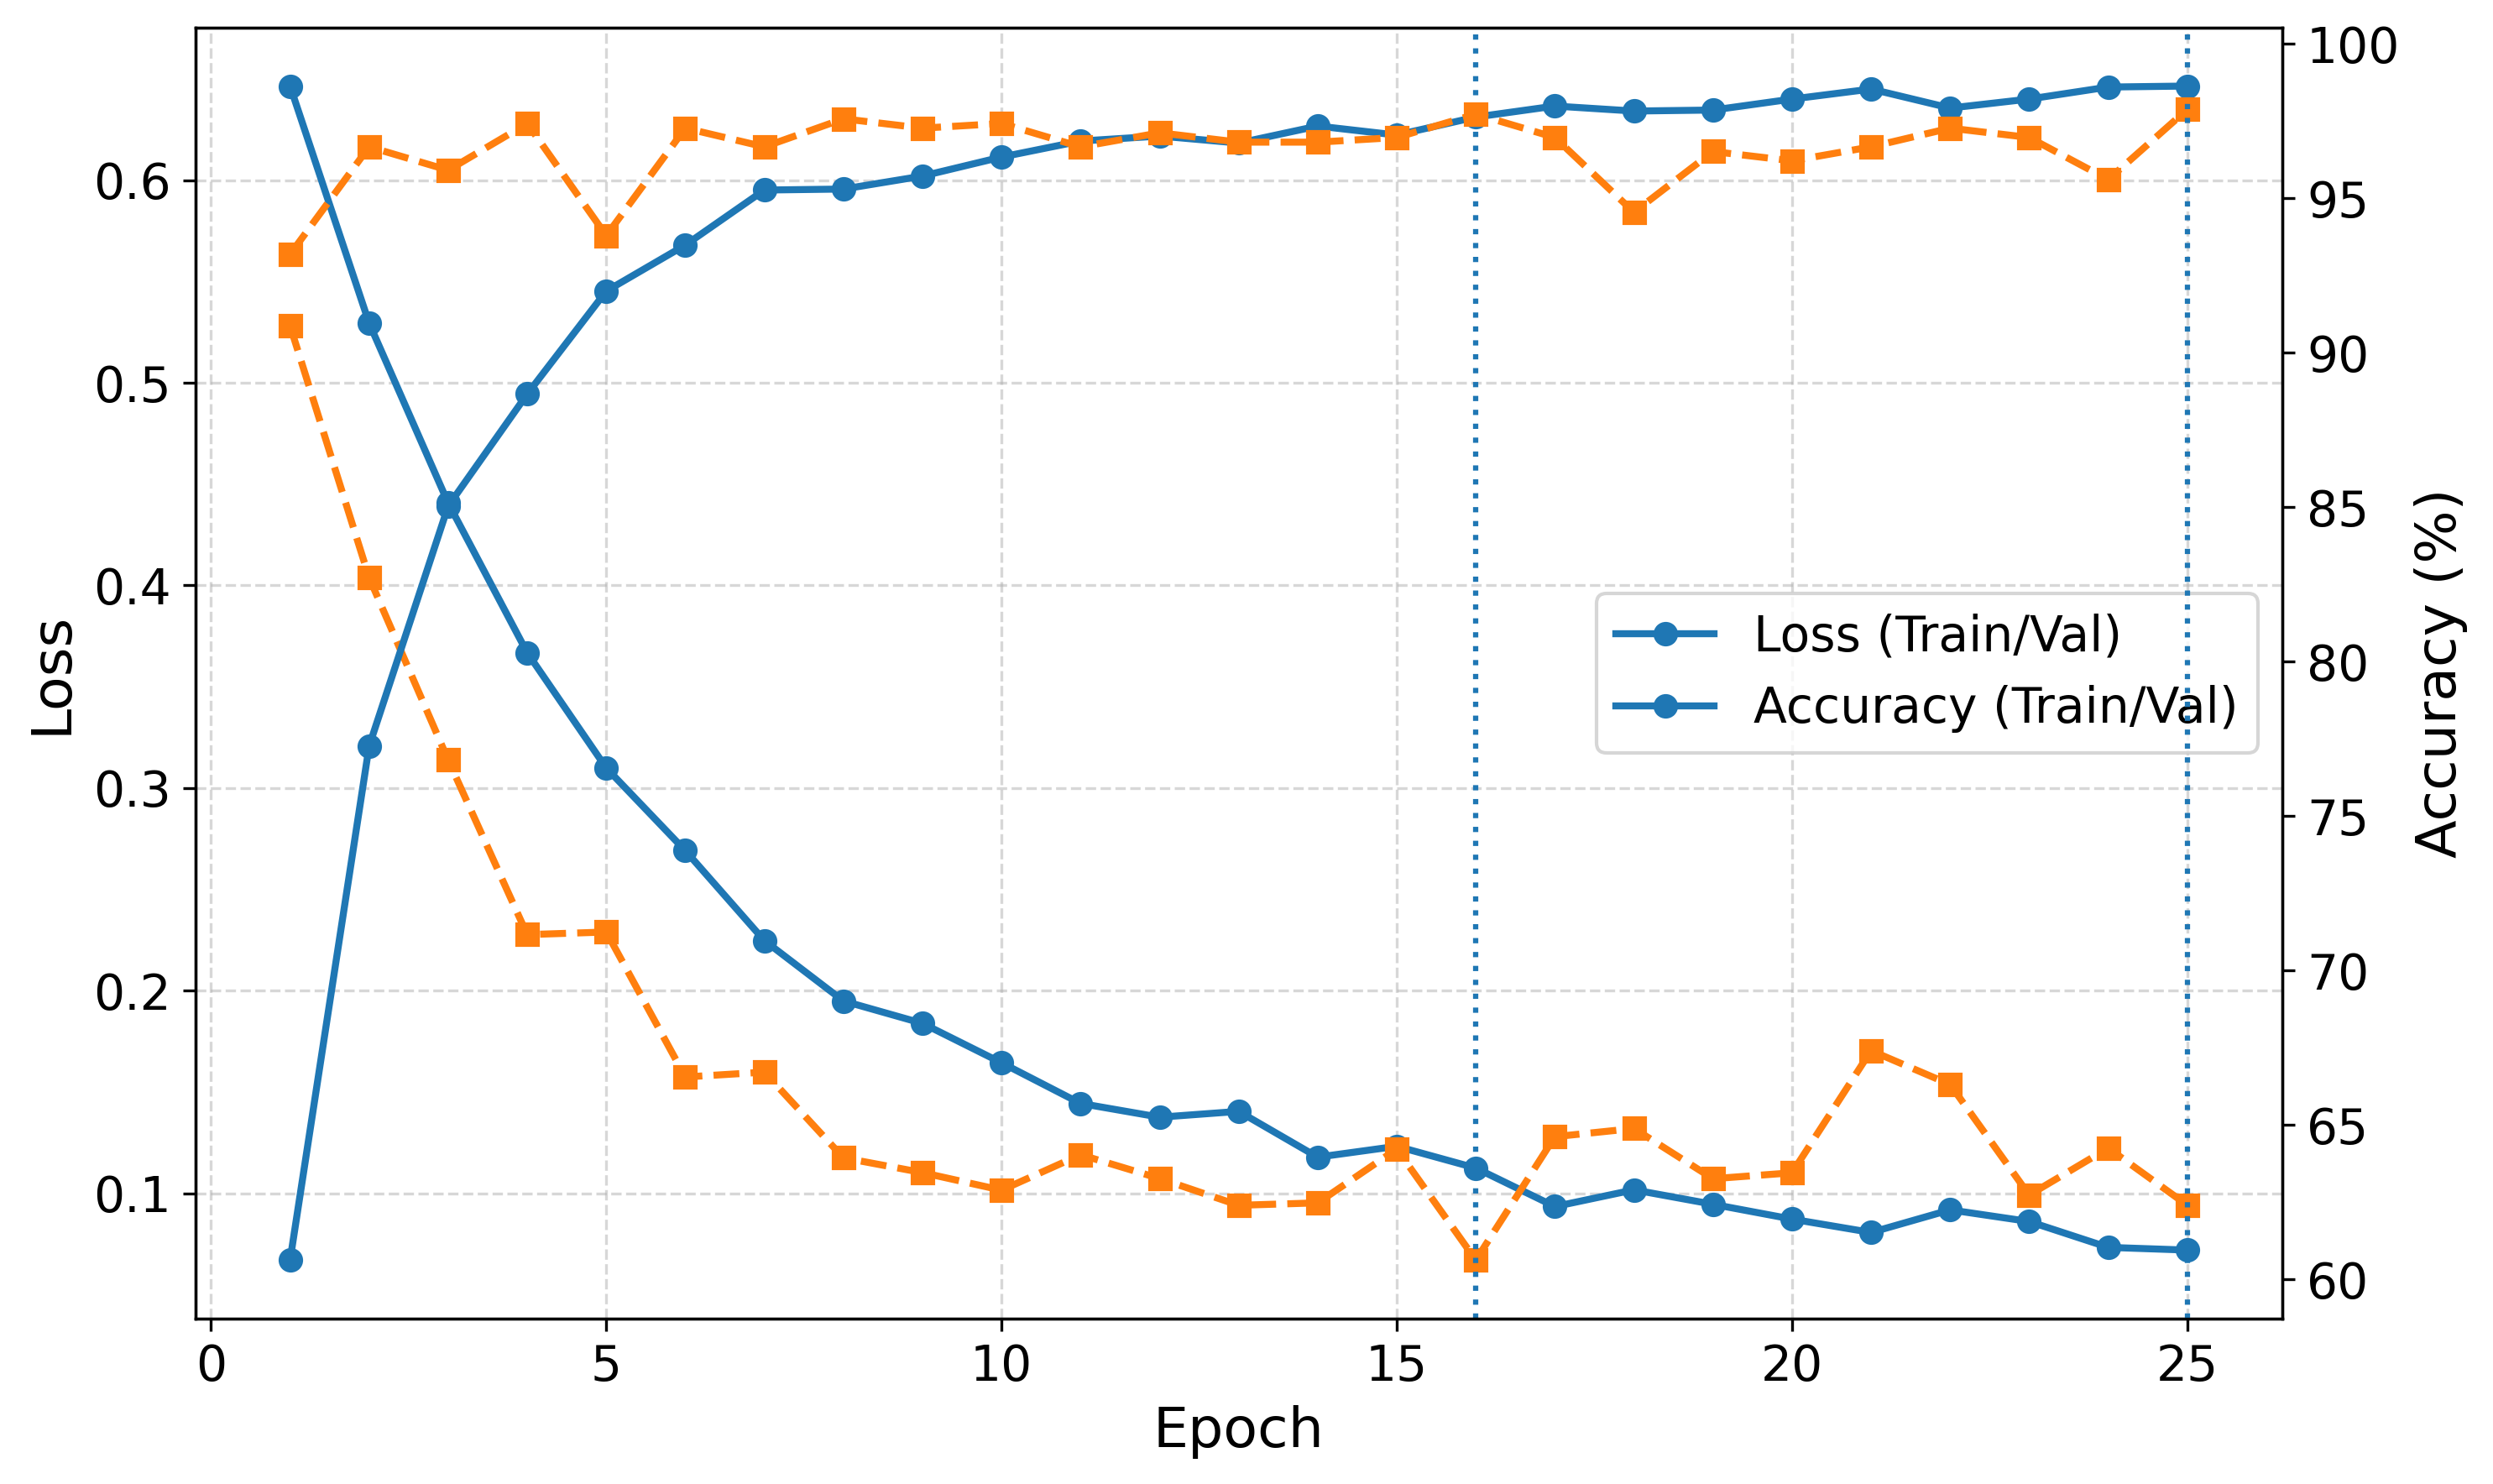

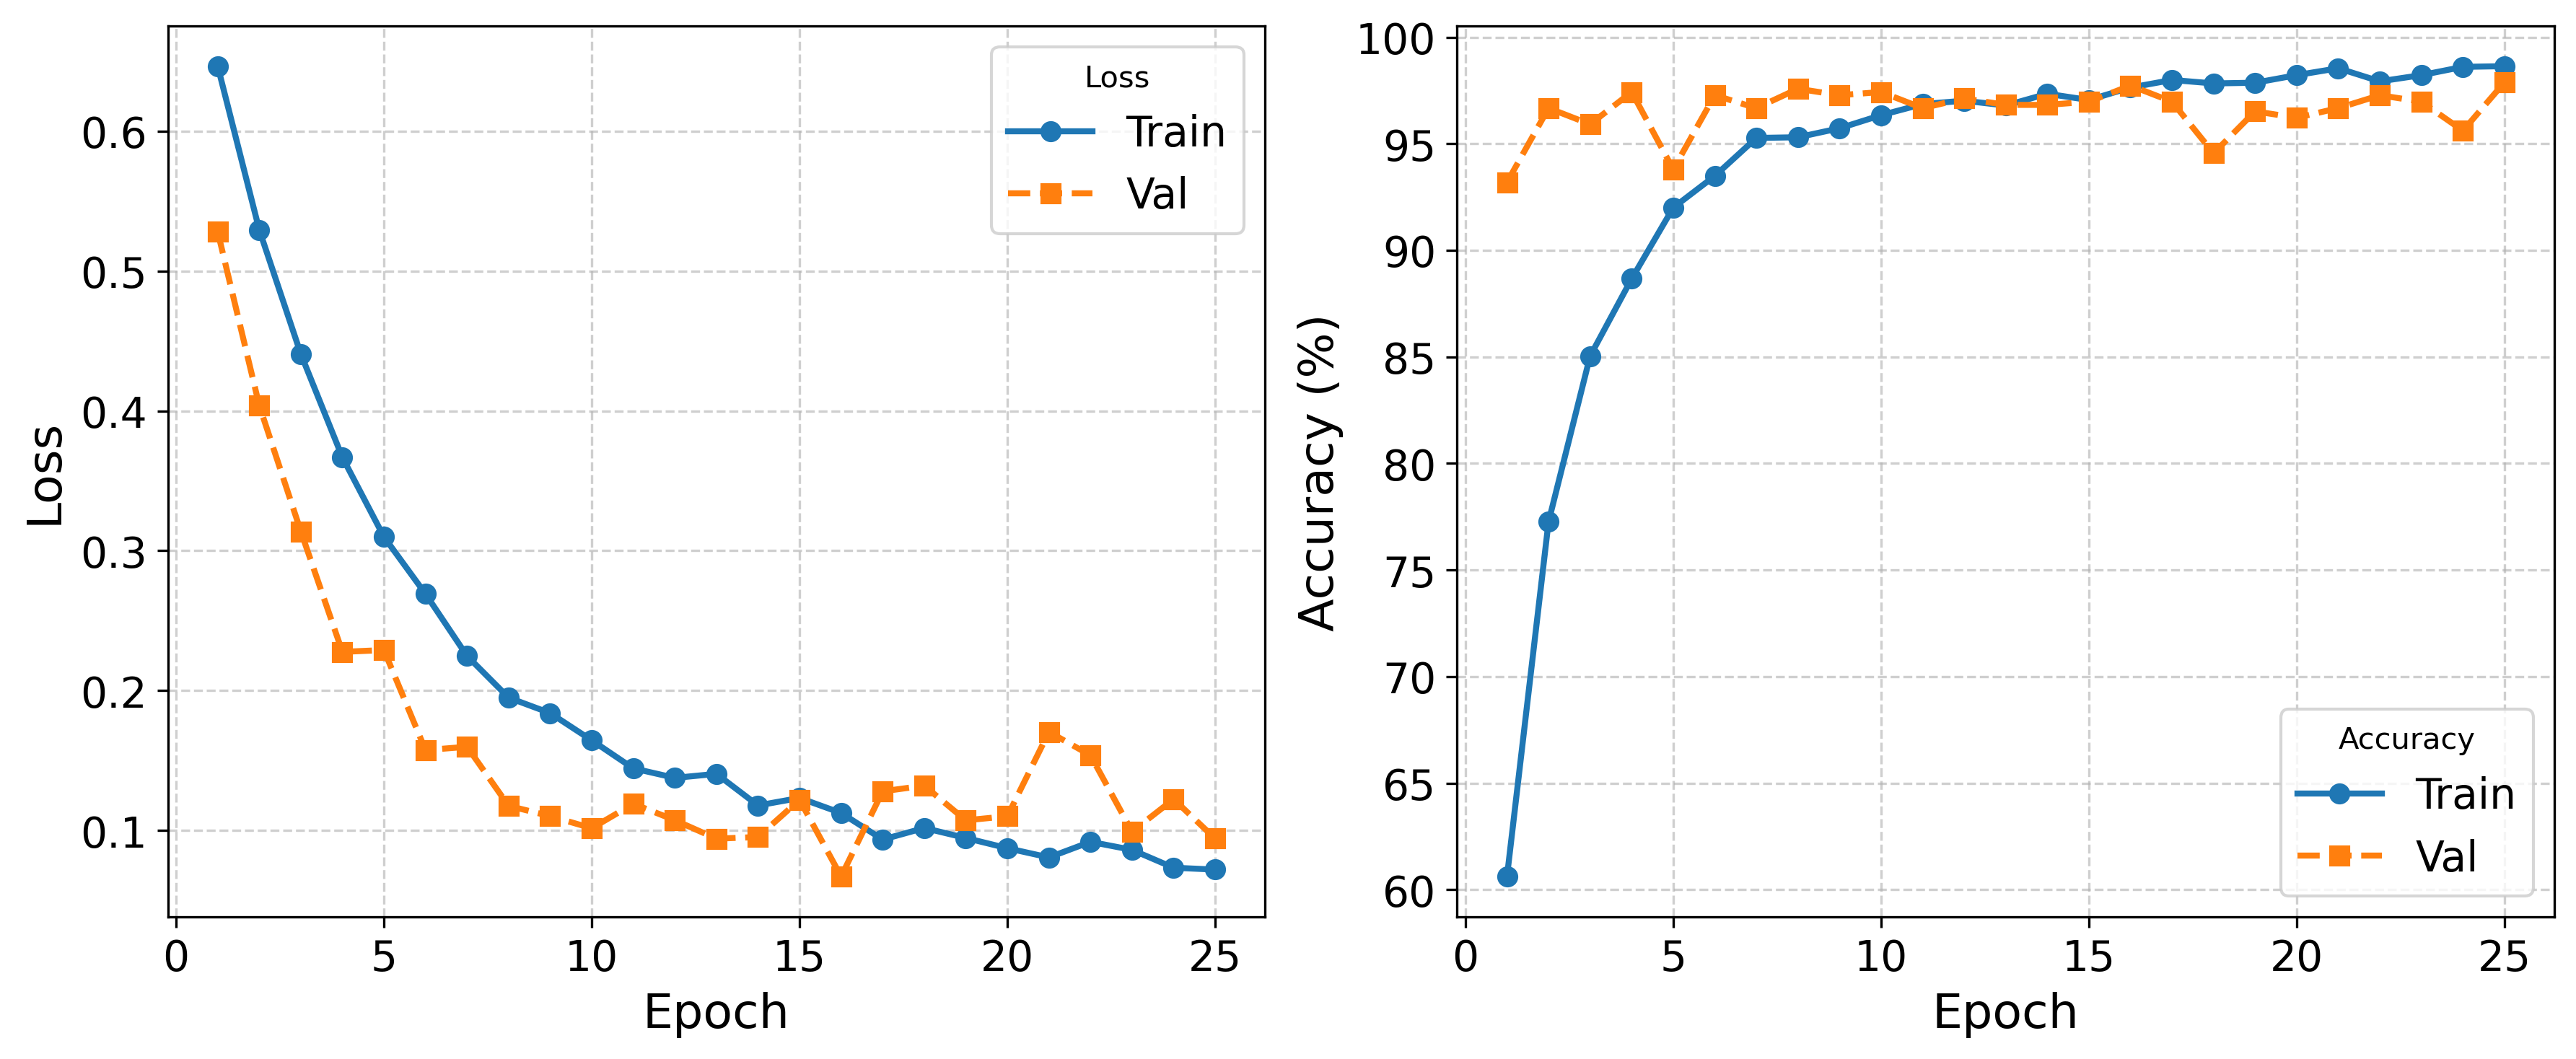

Saved CSV to: /home/HardDisk/yared/figures/learning_curves_new.csv


In [9]:
# ================================
# 6. High-quality visualizations + CSV export
# ================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ---- Prepare data as arrays ----
epochs_arr = np.arange(1, len(train_losses) + 1)
train_losses_np = np.asarray(train_losses, dtype=float)
val_losses_np   = np.asarray(val_losses,   dtype=float)
train_accs_np   = np.asarray(train_accs,   dtype=float) * (100.0 if train_accs[0] <= 1.0 else 1.0)  # pct-safe
val_accs_np     = np.asarray(val_accs,     dtype=float) * (100.0 if val_accs[0]   <= 1.0 else 1.0)

# ---- Find key epochs ----
best_val_acc_epoch  = int(epochs_arr[np.argmax(val_accs_np)])
best_val_acc        = float(np.max(val_accs_np))
best_val_loss_epoch = int(epochs_arr[np.argmin(val_losses_np)])
best_val_loss       = float(np.min(val_losses_np))

# ---- Output folder ----
out_dir = Path("figures")
out_dir.mkdir(parents=True, exist_ok=True)

# ---- Style knobs (tweak as you like) ----
AXIS_LABEL_SIZE = 16   # x/y label text
TICK_SIZE       = 14   # tick numbers
LEGEND_SIZE     = 14   # legend text
DPI_EXPORT      = 600  # raster export DPI

# ================================
# 6A. Compact dual-axis figure
# ================================
fig, ax_loss = plt.subplots(figsize=(10, 6), dpi=300)
ax_acc = ax_loss.twinx()

# Loss (left y-axis): Train = solid, Val = dashed
line_loss_train, = ax_loss.plot(epochs_arr, train_losses_np, marker='o', linewidth=2)
line_loss_val,   = ax_loss.plot(epochs_arr, val_losses_np,   marker='s', linewidth=2, linestyle='--')
ax_loss.set_xlabel('Epoch', fontsize=AXIS_LABEL_SIZE)
ax_loss.set_ylabel('Loss',  fontsize=AXIS_LABEL_SIZE)
ax_loss.tick_params(axis='both', labelsize=TICK_SIZE)
ax_loss.grid(True, linestyle='--', alpha=0.5)

# Accuracy (right y-axis): Train = solid, Val = dashed
line_acc_train, = ax_acc.plot(epochs_arr, train_accs_np, marker='o', linewidth=2)
line_acc_val,   = ax_acc.plot(epochs_arr, val_accs_np,   marker='s', linewidth=2, linestyle='--')
ax_acc.set_ylabel('Accuracy (%)', fontsize=AXIS_LABEL_SIZE)
ax_acc.tick_params(axis='both', labelsize=TICK_SIZE)

# Vertical markers for key epochs
ax_loss.axvline(best_val_loss_epoch, linestyle=':', linewidth=1.5)
ax_acc.axvline(best_val_acc_epoch,   linestyle=':', linewidth=1.5)

# # Annotations
# ax_acc.annotate(
#     f'Best Val Acc: {best_val_acc:.2f}% @ {best_val_acc_epoch}',
#     xy=(best_val_acc_epoch, best_val_acc),
#     xytext=(best_val_acc_epoch + 1, best_val_acc - 2),
#     arrowprops=dict(arrowstyle='->', lw=1),
#     fontsize=12
# )
# ax_loss.annotate(
#     f'Lowest Val Loss: {best_val_loss:.3f} @ {best_val_loss_epoch}',
#     xy=(best_val_loss_epoch, best_val_loss),
#     xytext=(best_val_loss_epoch + 1, best_val_loss + 0.05),
#     arrowprops=dict(arrowstyle='->', lw=1),
#     fontsize=12
# )


# Two entries: Loss (Train/Val), Accuracy (Train/Val)
legend_elements = [
    plt.Line2D([0], [0], marker='o', linestyle='-',  linewidth=2, label='Loss (Train/Val)'),
    plt.Line2D([0], [0], marker='o', linestyle='-',  linewidth=2, label='Accuracy (Train/Val)'),
]
# Keep the actual line styles in the plot: solid=Train, dashed=Val (explained by caption/labels)
ax_loss.legend(handles=legend_elements, loc='center right', fontsize=LEGEND_SIZE, frameon=True)

plt.tight_layout()

# Save (PNG/PDF/SVG/EPS)
base = out_dir / "learning_curves_dual_axis"
plt.savefig(base.with_suffix(".png"), dpi=DPI_EXPORT, bbox_inches="tight")
plt.savefig(base.with_suffix(".pdf"),                bbox_inches="tight")
plt.savefig(base.with_suffix(".svg"),                bbox_inches="tight")
plt.savefig(base.with_suffix(".eps"),                bbox_inches="tight")   # EPS flattens transparency
plt.show()

# ================================
# 6B. Classic 2-panel figure
# ================================
fig = plt.figure(figsize=(12, 5), dpi=300)

# Left: Loss
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs_arr, train_losses_np, marker='o', linewidth=2, label='Train')
ax1.plot(epochs_arr, val_losses_np,   marker='s', linewidth=2, linestyle='--', label='Val')
ax1.set_xlabel('Epoch', fontsize=AXIS_LABEL_SIZE)
ax1.set_ylabel('Loss',  fontsize=AXIS_LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(title='Loss', fontsize=LEGEND_SIZE, frameon=True)

# Right: Accuracy
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs_arr, train_accs_np, marker='o', linewidth=2, label='Train')
ax2.plot(epochs_arr, val_accs_np,   marker='s', linewidth=2, linestyle='--', label='Val')
ax2.set_xlabel('Epoch', fontsize=AXIS_LABEL_SIZE)
ax2.set_ylabel('Accuracy (%)', fontsize=AXIS_LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(title='Accuracy', fontsize=LEGEND_SIZE, frameon=True)

plt.tight_layout()
base2 = out_dir / "learning_curves_2panel"
plt.savefig(base2.with_suffix(".png"), dpi=DPI_EXPORT, bbox_inches="tight")
plt.savefig(base2.with_suffix(".pdf"),                bbox_inches="tight")
plt.savefig(base2.with_suffix(".svg"),                bbox_inches="tight")
plt.savefig(base2.with_suffix(".eps"),                bbox_inches="tight")
plt.show()

# ================================
# 6C. CSV export for reproducibility
# ================================
df = pd.DataFrame({
    "epoch": epochs_arr,
    "train_loss": train_losses_np,
    "val_loss":   val_losses_np,
    "train_acc":  train_accs_np,
    "val_acc":    val_accs_np
})
csv_path = out_dir / "learning_curves_new.csv"
df.to_csv(csv_path, index=False)
print(f"Saved CSV to: {csv_path.resolve()}")


 # Visualizaitons

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


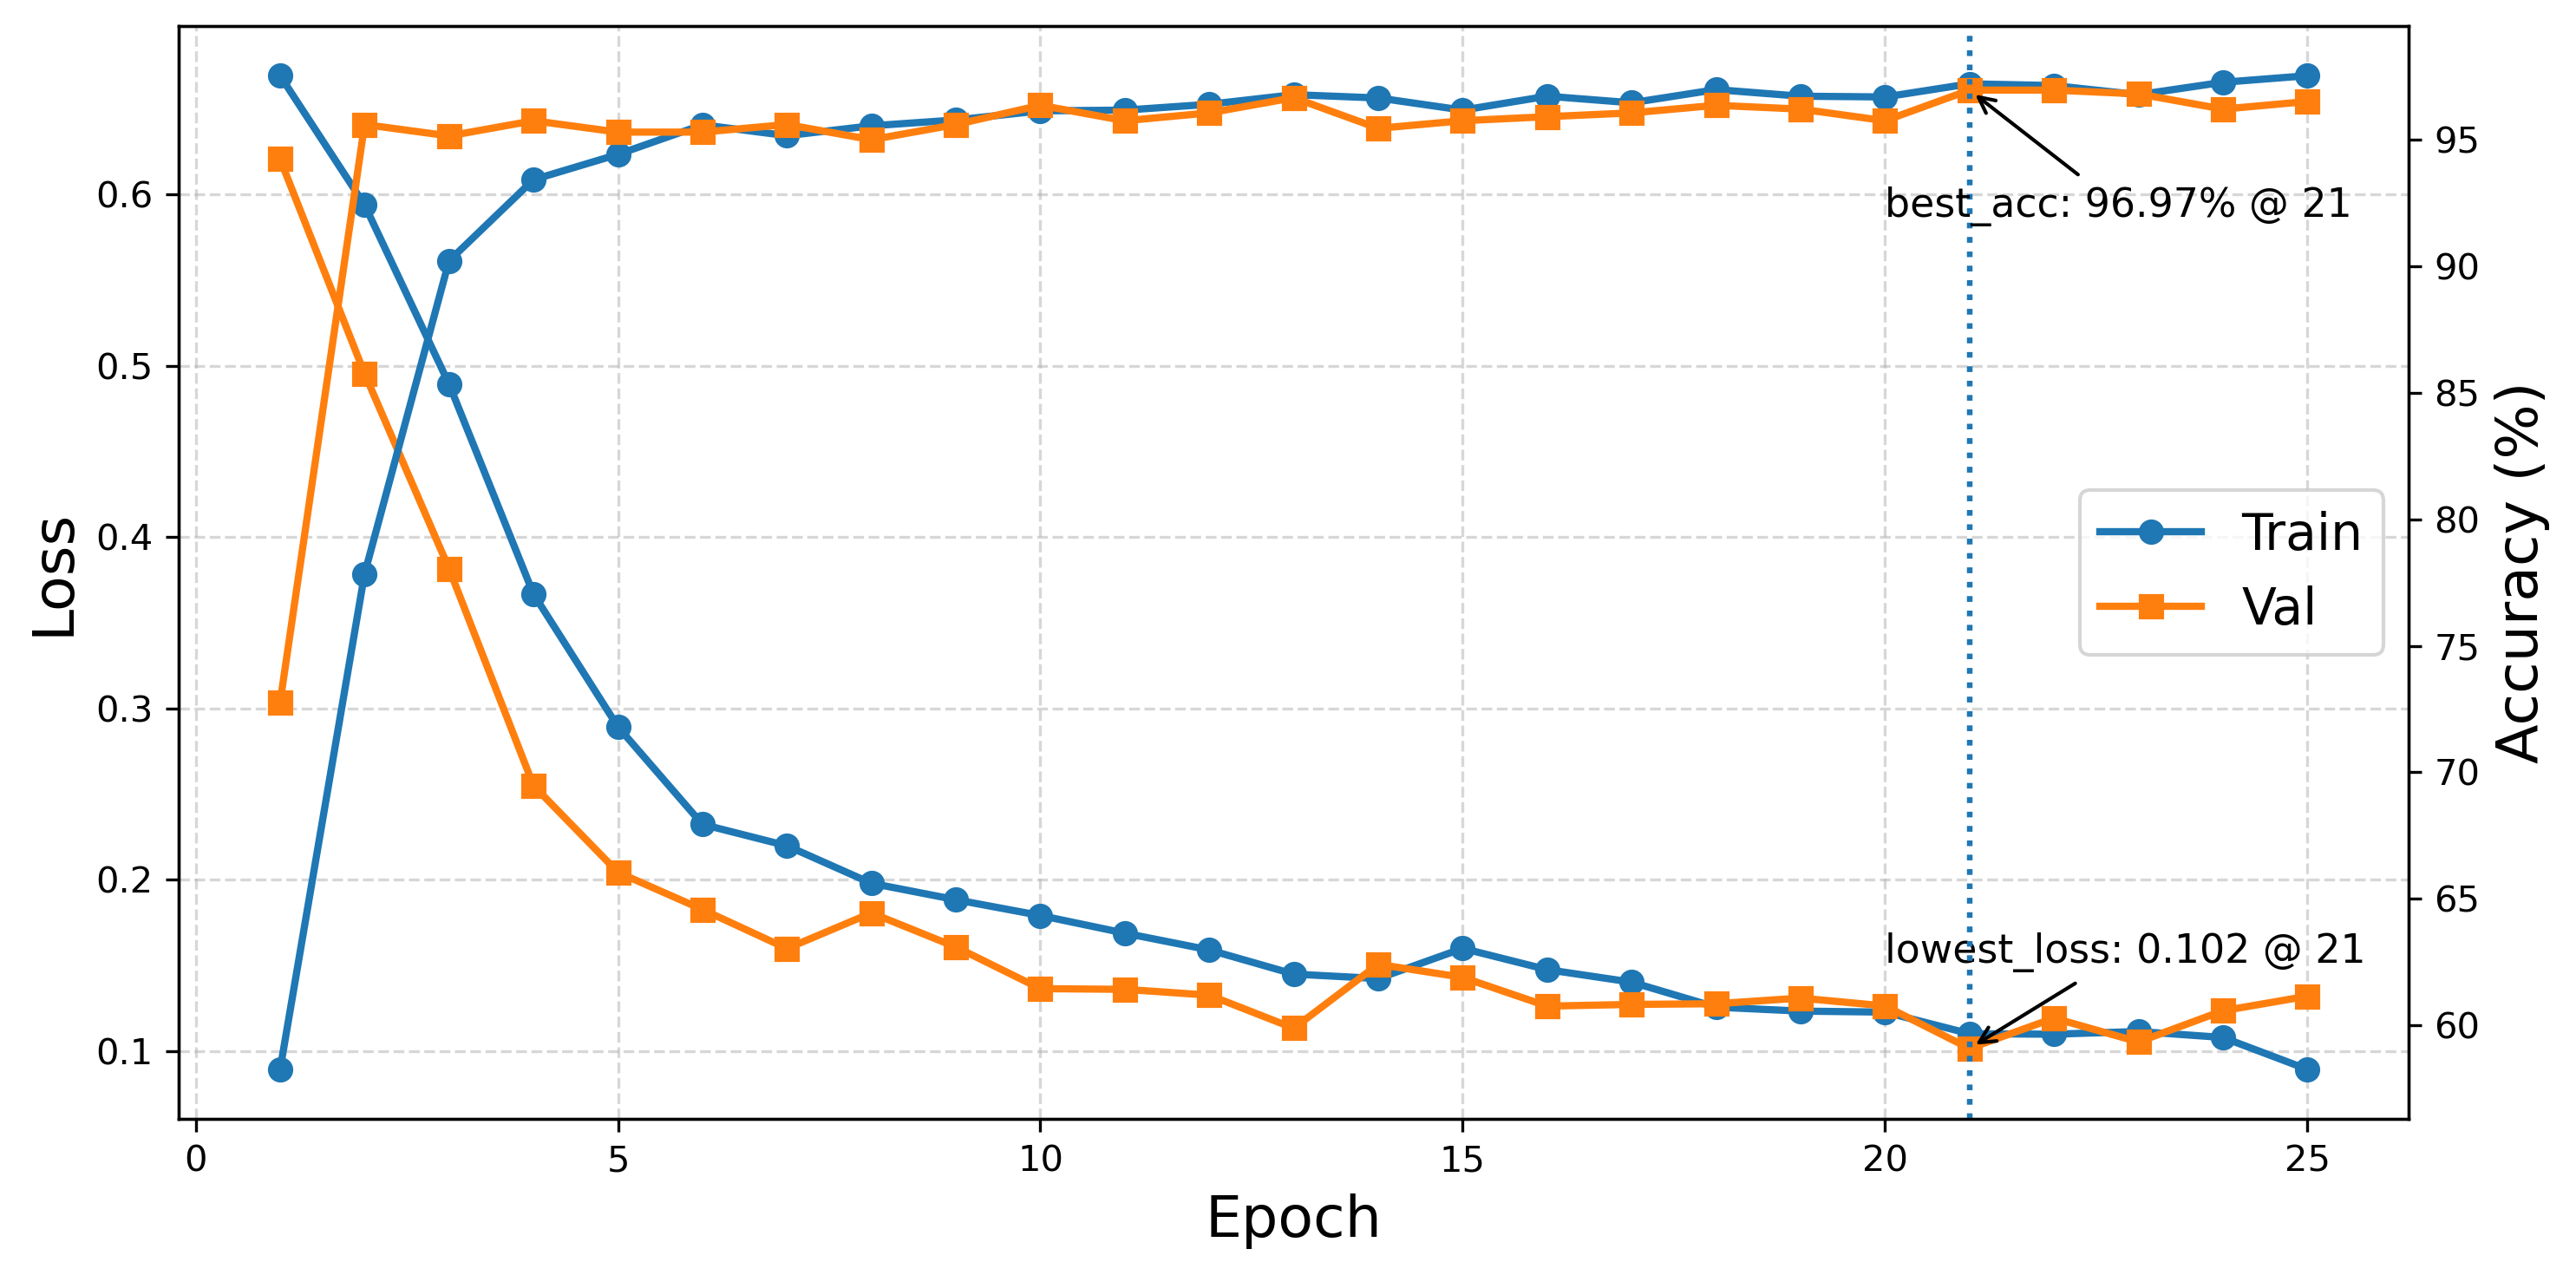

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Data (from your logs) ----
epochs = np.arange(1, 26)

train_losses = np.array([
    0.6693, 0.5939, 0.4893, 0.3667, 0.2892, 0.2323, 0.2198, 0.1979, 0.1883, 0.1791,
    0.1688, 0.1590, 0.1449, 0.1423, 0.1599, 0.1475, 0.1402, 0.1256, 0.1233, 0.1227,
    0.1101, 0.1098, 0.1114, 0.1079, 0.0893
])
val_losses = np.array([
    0.6206, 0.4954, 0.3816, 0.2549, 0.2043, 0.1826, 0.1598, 0.1806, 0.1607, 0.1364,
    0.1360, 0.1326, 0.1133, 0.1506, 0.1430, 0.1262, 0.1272, 0.1276, 0.1309, 0.1263,
    0.1015, 0.1192, 0.1053, 0.1235, 0.1320
])
train_accs = np.array([
    58.26, 77.85, 90.22, 93.43, 94.43, 95.60, 95.17, 95.56, 95.79, 96.15,
    96.18, 96.41, 96.79, 96.66, 96.18, 96.73, 96.47, 96.99, 96.73, 96.70,
    97.22, 97.15, 96.79, 97.28, 97.54
])
val_accs = np.array([
    72.77, 95.61, 95.16, 95.76, 95.31, 95.31, 95.61, 95.01, 95.61, 96.37,
    95.76, 96.07, 96.67, 95.46, 95.76, 95.92, 96.07, 96.37, 96.22, 95.76,
    96.97, 96.97, 96.82, 96.22, 96.52
])

# ---- Find key epochs ----
best_val_acc_epoch = int(epochs[np.argmax(val_accs)])
best_val_acc = float(np.max(val_accs))
best_val_loss_epoch = int(epochs[np.argmin(val_losses)])
best_val_loss = float(np.min(val_losses))

# ---- Plot (dual y-axes) ----
fig, ax_loss = plt.subplots(figsize=(10, 5), dpi=300)
ax_acc = ax_loss.twinx()


# Loss curves (left axis)
l1, = ax_loss.plot(epochs, train_losses, marker='o', linewidth=2, label='Train Loss')
l2, = ax_loss.plot(epochs, val_losses, marker='s', linewidth=2, label='Val Loss')
ax_loss.set_xlabel('Epoch', fontsize=16)
ax_loss.set_ylabel('Loss', fontsize=16)
ax_loss.grid(True, linestyle='--', alpha=0.5)

# Accuracy curves (right axis)
l3, = ax_acc.plot(epochs, train_accs, marker='o', linewidth=2, label='Train Acc')
l4, = ax_acc.plot(epochs, val_accs, marker='s', linewidth=2, label='Val Acc')
ax_acc.set_ylabel('Accuracy (%)', fontsize=16)

# Vertical lines at key epochs
ax_loss.axvline(best_val_loss_epoch, linestyle=':', linewidth=1.5)
ax_acc.axvline(best_val_acc_epoch, linestyle=':', linewidth=1.5)

# Annotations
ax_acc.annotate(
    f'best_acc: {best_val_acc:.2f}% @ {best_val_acc_epoch}',
    xy=(best_val_acc_epoch, best_val_acc),
    xytext=(best_val_acc_epoch-1, best_val_acc-5),
    arrowprops=dict(arrowstyle='->', lw=1),
    fontsize=11
)
ax_loss.annotate(
    f'lowest_loss: {best_val_loss:.3f} @ {best_val_loss_epoch}',
    xy=(best_val_loss_epoch, best_val_loss),
    xytext=(best_val_loss_epoch-1, best_val_loss+0.05),
    arrowprops=dict(arrowstyle='->', lw=1),
    fontsize=11
)


# Combined legend (two labels: Train, Val)
from matplotlib.lines import Line2D
train_proxy = Line2D([0], [0], color=l1.get_color(), marker='o', linewidth=2, label='Train')
val_proxy = Line2D([0], [0], color=l2.get_color(), marker='s', linewidth=2, label='Val')
ax_loss.legend([train_proxy, val_proxy], ['Train', 'Val'], loc='center right', fontsize=14, frameon=True)

plt.tight_layout()

# ---- Save in multiple formats ----
out_base = "learning_curves_final"
plt.savefig(out_base + ".png", dpi=600, bbox_inches="tight")
plt.savefig(out_base + ".pdf", bbox_inches="tight")
plt.savefig(out_base + ".svg", bbox_inches="tight")
plt.savefig(out_base + ".eps", bbox_inches="tight")  # note: EPS flattens transparency
plt.show()


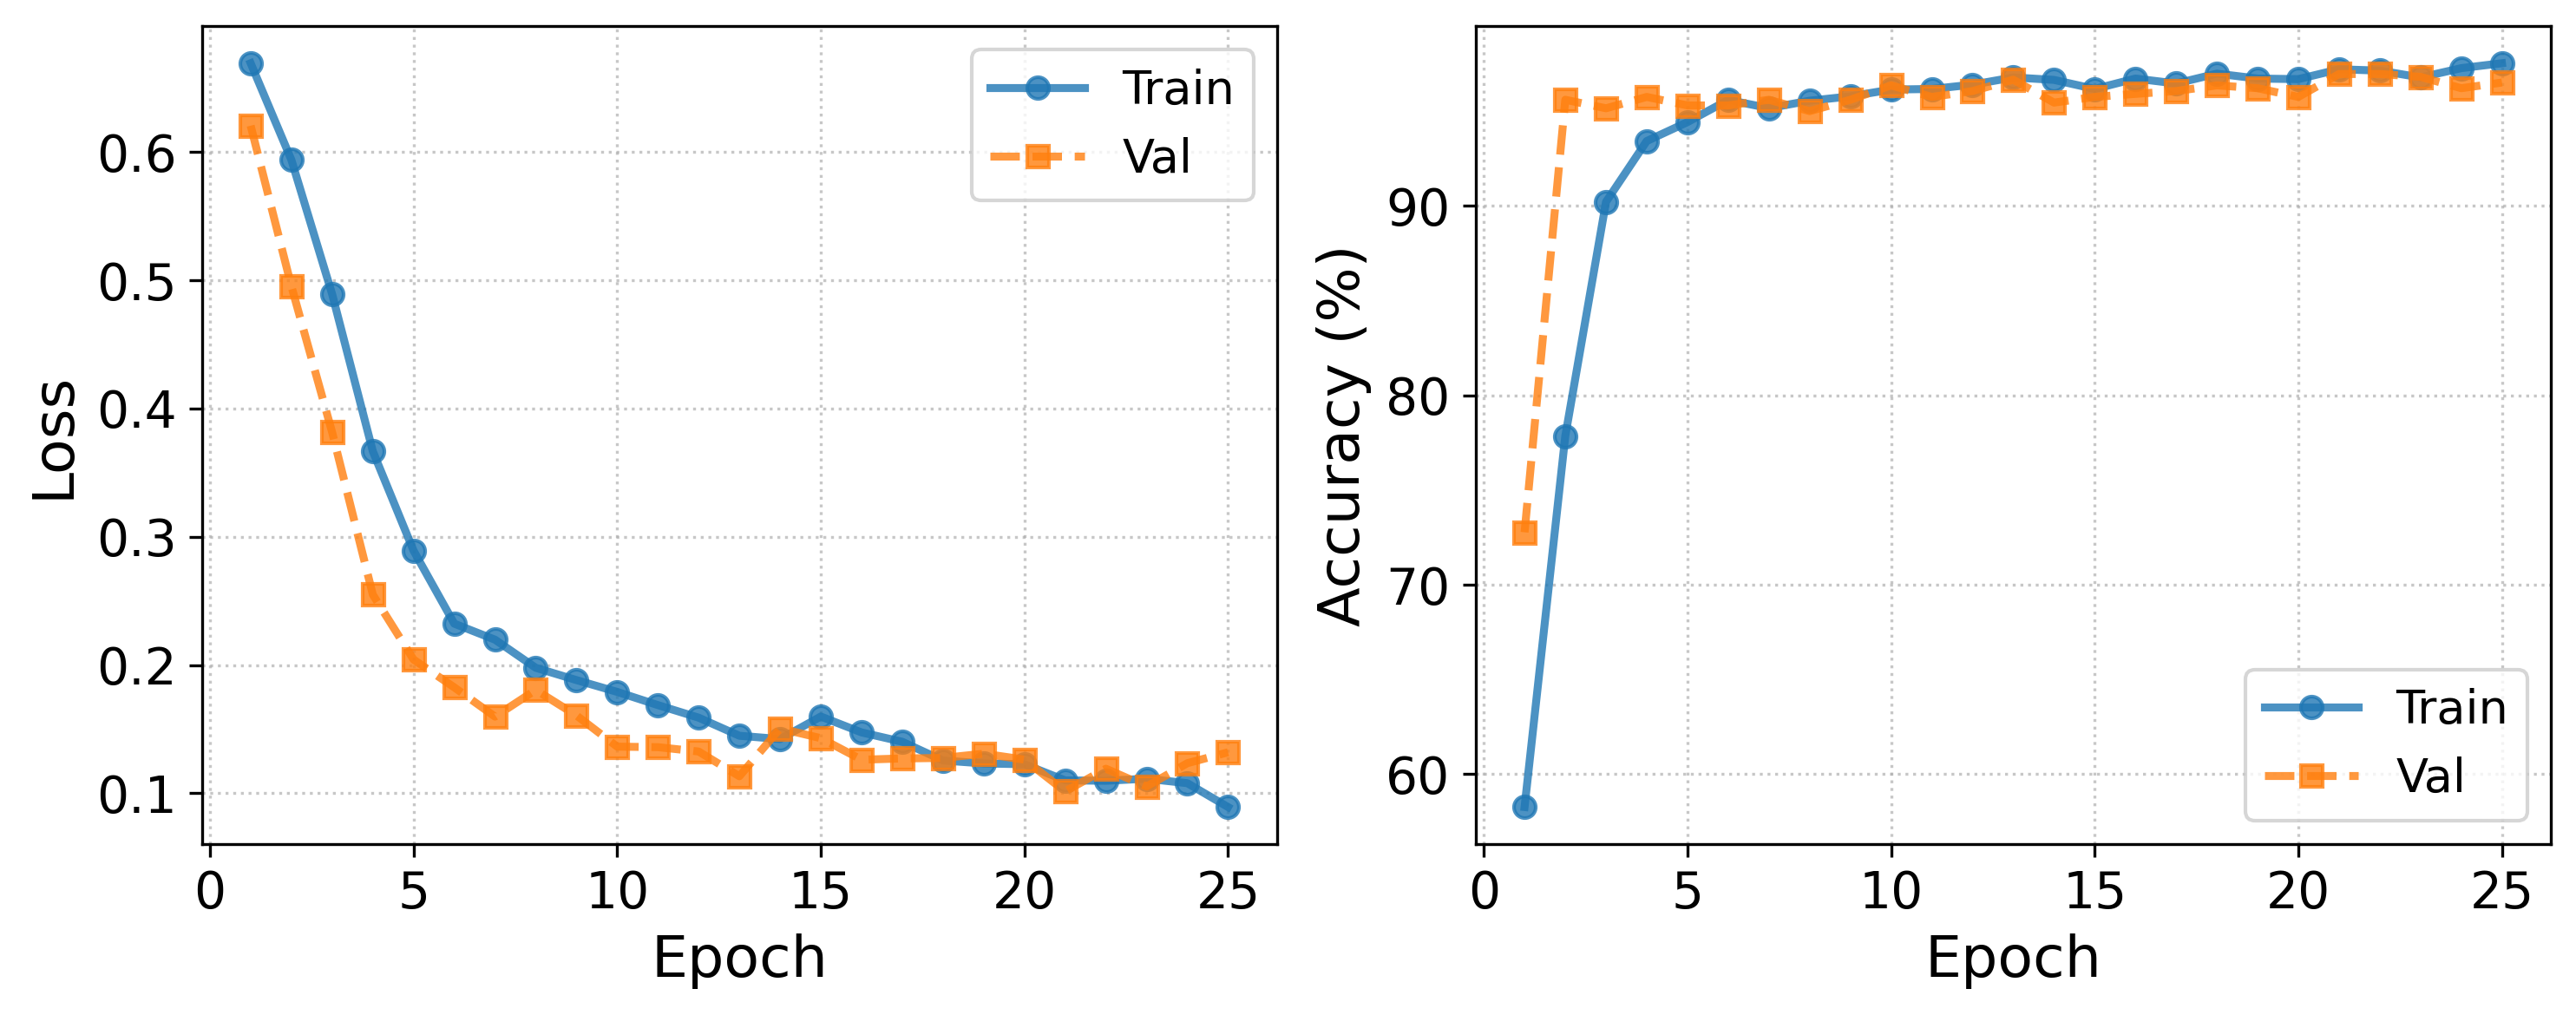

Saved CSV to: /home/HardDisk/yared/figures/baseline_learning_curves.csv


In [2]:
# Baseline learning curves: Loss and Accuracy side by side
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ================================
# 1. Preparation data
# ================================
epochs_arr = np.arange(1, len(train_losses) + 1)
train_losses_np = np.asarray(train_losses, dtype=float)
val_losses_np   = np.asarray(val_losses,   dtype=float)
train_accs_np   = np.asarray(train_accs,   dtype=float) * (100.0 if train_accs[0] <= 1.0 else 1.0)
val_accs_np     = np.asarray(val_accs,     dtype=float) * (100.0 if val_accs[0]   <= 1.0 else 1.0)

# ================================
# 2. Style parameters (matchin to attack/defense figs)
# ================================
FIGSIZE = (10, 4)    
DPI = 300
LINEWIDTH = 2.2
ALPHA = 0.8

AXIS_LABEL_SIZE = 16
TICK_SIZE       = 14
LEGEND_SIZE     = 13
FONT_FAMILY     = "DejaVu Sans"  # or "Times New Roman" 

plt.rcParams.update({
    "font.family": FONT_FAMILY,
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "axes.labelsize": AXIS_LABEL_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
})

# ================================
# 3. Two-panel figure
# ================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE, dpi=DPI)

# --- Loss (left) ---
ax1.plot(epochs_arr, train_losses_np, marker='o', linewidth=LINEWIDTH, alpha=ALPHA, label='Train')
ax1.plot(epochs_arr, val_losses_np,   marker='s', linewidth=LINEWIDTH, alpha=ALPHA,
         linestyle='--', label='Val')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True, linestyle=":", alpha=0.7)
ax1.legend(loc="upper right", frameon=True, fancybox=True)

# --- Accuracy (right) ---
ax2.plot(epochs_arr, train_accs_np, marker='o', linewidth=LINEWIDTH, alpha=ALPHA, label='Train')
ax2.plot(epochs_arr, val_accs_np,   marker='s', linewidth=LINEWIDTH, alpha=ALPHA,
         linestyle='--', label='Val')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True, linestyle=":", alpha=0.7)
ax2.legend(loc="lower right", frameon=True, fancybox=True)

fig.tight_layout()

# ================================
# 4. Save outputs (IEEE formats)
# ================================
out_dir = Path("figures")
out_dir.mkdir(parents=True, exist_ok=True)

base = out_dir / "baseline_learning_curves"
fig.savefig(base.with_suffix(".pdf"), bbox_inches="tight")
fig.savefig(base.with_suffix(".png"), bbox_inches="tight", dpi=600)
fig.savefig(base.with_suffix(".svg"), bbox_inches="tight")

plt.show()

# ================================
# 5. Export CSV for reproducibility
# ================================
df = pd.DataFrame({
    "epoch": epochs_arr,
    "train_loss": train_losses_np,
    "val_loss":   val_losses_np,
    "train_acc":  train_accs_np,
    "val_acc":    val_accs_np
})
csv_path = out_dir / "baseline_learning_curves.csv"
df.to_csv(csv_path, index=False)
print(f"Saved CSV to: {csv_path.resolve()}")
